In [1]:
import numpy as np
import trimesh
import geopandas as gpd
import pandas as pd
from shapely import geometry
from skimage import measure

from rbf.interpolate import KNearestRBFInterpolant as KNRBFInterpolant
import matplotlib.pyplot as plt

In [2]:
from boreholes_helper import Boreholes, BoreholeModel

In [3]:
from scipy import signal
from scipy.interpolate import RBFInterpolator

In [4]:
# PANDAS CONFIG
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = None

# PLT CONFIG
plt.rcParams['figure.figsize'] = [15, 7]

In [5]:
# a = Boreholes()
a = BoreholeModel()

In [6]:
a.setCollar(
    path='./BAKAN_COLLAR.CSV',
    x='UTM_EAST',
    y='UTM_NORTH',
    z='RL',
    depth='TDEPTH',
    keys=['BHID'],
    id='BHID',
)
a.readCollar()
a.applyCollarConfigMap()
a.createCollarPointGeometry()
a.updateCollarCrs(32651)

# create metric geometry
df = a.getDataFrame('collar')
df = Boreholes.changeCrs(df, srid=32651)
df['geometryMetric'] = df['geometry']
df = Boreholes.changeCrs(df, srid=4326)
a.setDataFrame('collar', df)

a.setCollar(srid=4326)
a.createCollarLineSegment(key='geometryMetric')
# a.viewCollarLine().show()

/media/lelegoyang/OS/DevTeam/jupyter_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [7]:
a.setSurvey(
    path='./BAKAN_SURVEY.CSV',
    depth='AT',
    dip='DM_DIP',
    azimuth='UTM_BRG',
    keys=['BHID'],
    id='BHID',
)
a.readSurvey()
a.applySurveyConfigMap()

In [8]:
a.setInterval(
    path='./BAKAN_ASSAY.CSV',
    z0='FROM',
    z1='TO',
    keys=['BHID'],
    id='BHID',
    x='UTM_EAST',
    y='UTM_NORTH',
    z='RL',
)
a.readInterval()
a.applyIntervalConfigMap()

In [9]:
areas = {
    'a': { # why the-f they keep raising singular matrix error in this area?
        'xmin': 112.30,
        'xmax': 112.305,
        'ymin': 0.565,
        'ymax': 0.58,
    },
    'b': {
        'xmin': 112.3157,
        'xmax': 112.32,
        'ymin': 0.575,
        'ymax': 0.6,
    },
    'c': {
        'xmin': 112.30,
        'xmax': 112.312,
        'ymin': 0.54,
        'ymax': 0.565,
    },
    'd': { # two borehole
        'xmin': 112.30,
        'xmax': 112.302,
        'ymin': 0.564,
        'ymax': 0.565,
    },
}


area  d {'xmin': 112.3, 'xmax': 112.302, 'ymin': 0.564, 'ymax': 0.565}


2it [00:01,  1.10it/s]


{'explained_variance_score': 1.0, 'root_mean_square_error': 4.740180225519544e-14}


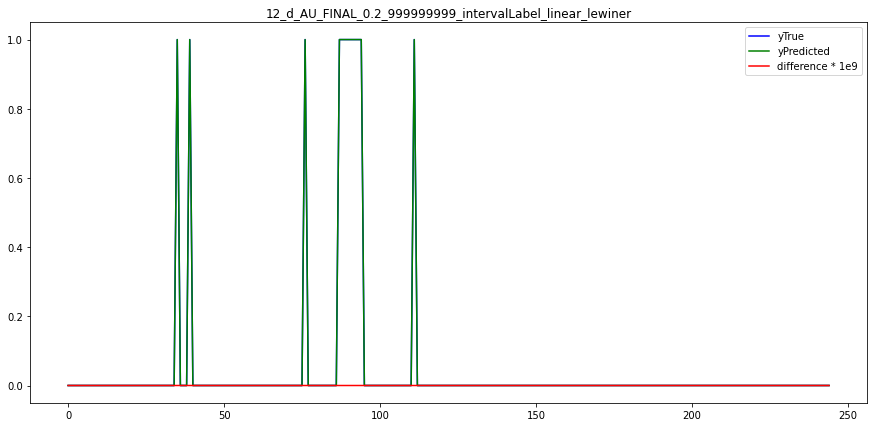

12_d_AU_FINAL_0.2_999999999_intervalLabel_linear_lewiner.glb
{'explained_variance_score': 1.0, 'root_mean_square_error': 4.1029748473604075e-13}


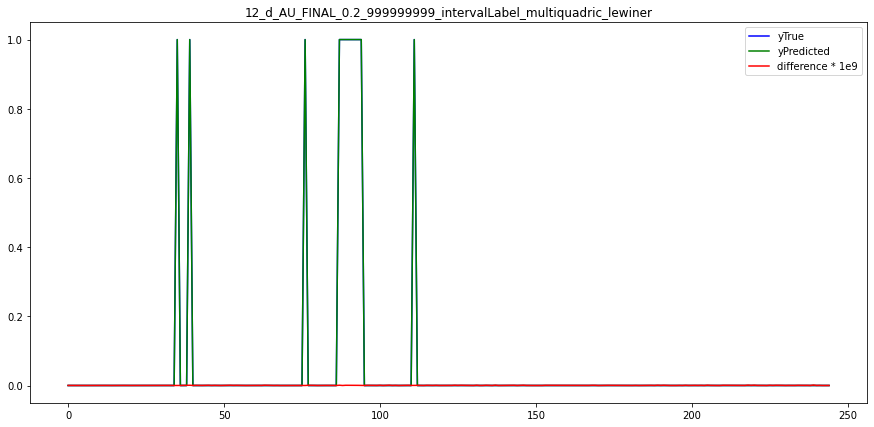

12_d_AU_FINAL_0.2_999999999_intervalLabel_multiquadric_lewiner.glb
{'explained_variance_score': 1.0, 'root_mean_square_error': 1.4754888270217628e-16}


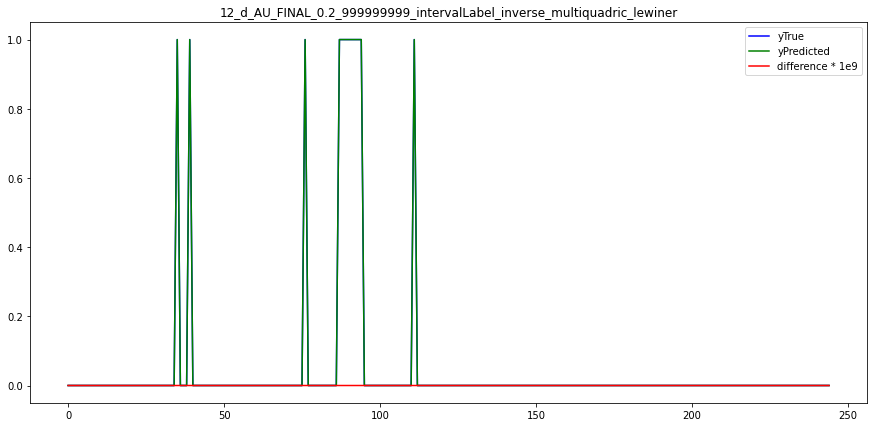

12_d_AU_FINAL_0.2_999999999_intervalLabel_inverse_multiquadric_lewiner.glb
{'explained_variance_score': 1.0, 'root_mean_square_error': 9.214978211354759e-17}


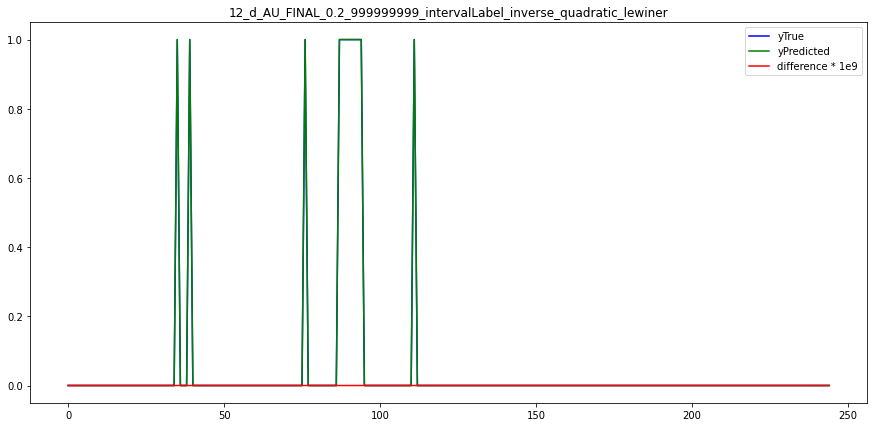

12_d_AU_FINAL_0.2_999999999_intervalLabel_inverse_quadratic_lewiner.glb
{'explained_variance_score': 1.0, 'root_mean_square_error': 3.304664714994621e-17}


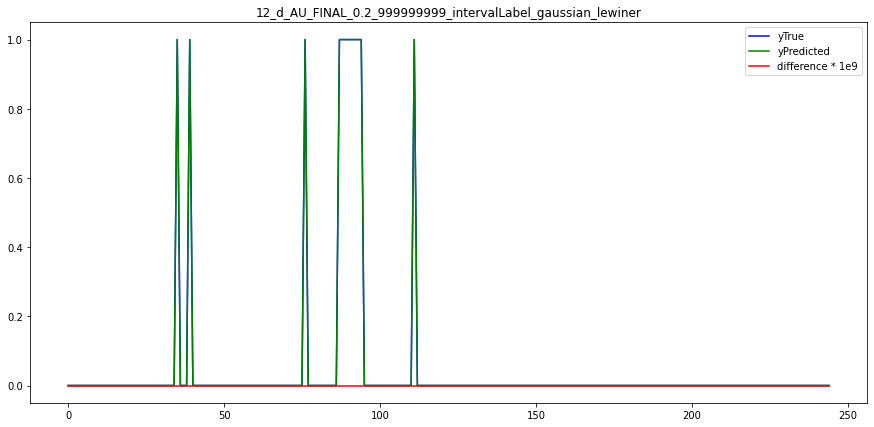

12_d_AU_FINAL_0.2_999999999_intervalLabel_gaussian_lewiner.glb
{'explained_variance_score': 1.0, 'root_mean_square_error': 1.0294058357504352e-09}


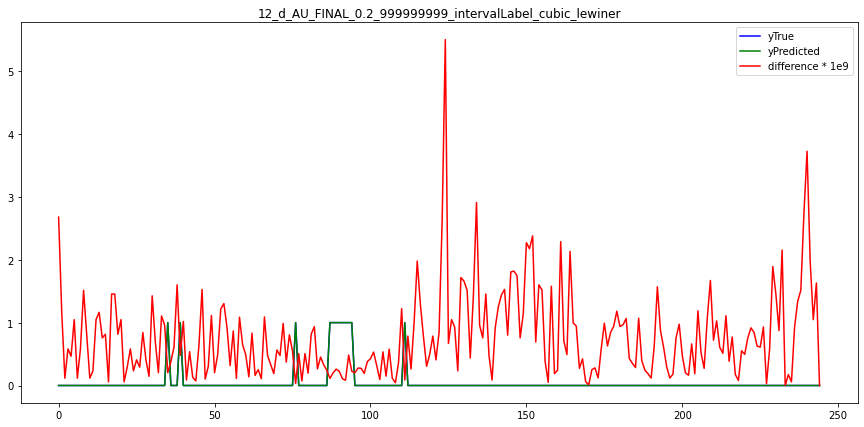

12_d_AU_FINAL_0.2_999999999_intervalLabel_cubic_lewiner.glb
{'explained_variance_score': 1.0, 'root_mean_square_error': 1.1354770006150873e-10}


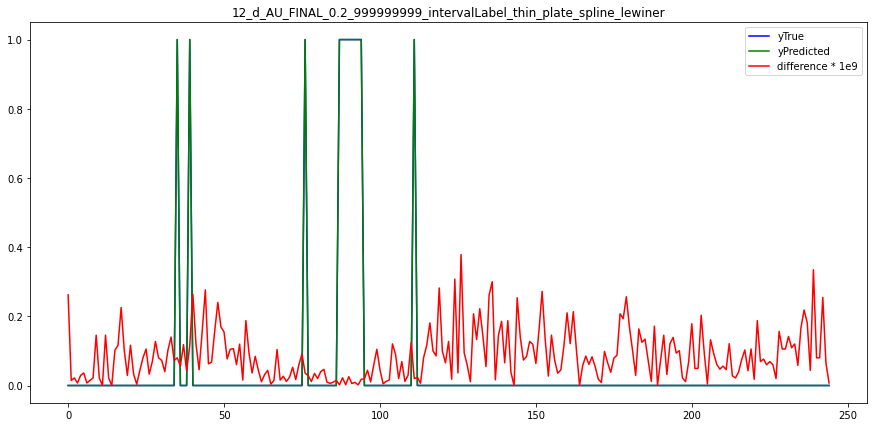

12_d_AU_FINAL_0.2_999999999_intervalLabel_thin_plate_spline_lewiner.glb
{'explained_variance_score': 0.9999999996328857, 'root_mean_square_error': 4.348143956161327e-06}


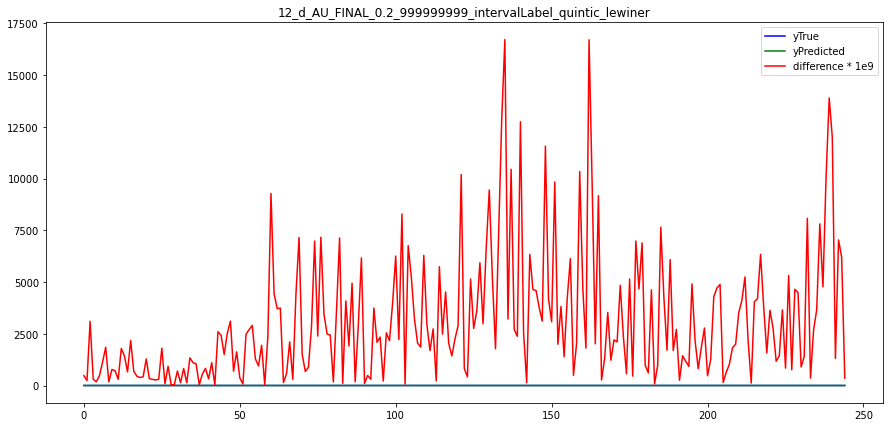

12_d_AU_FINAL_0.2_999999999_intervalLabel_quintic_lewiner.glb


In [10]:
interpolatorKernels = ['linear', 'multiquadric', 'inverse_multiquadric', 'inverse_quadratic', 'gaussian', 'cubic', 'thin_plate_spline', 'quintic']
# interpolatorKernels = ['linear', 'multiquadric', 'inverse_multiquadric', 'inverse_quadratic', 'gaussian'] # first try success
# interpolatorkernels = ['multiquadric'] # diamond-like surface and some missing spots
# interpolatorkernels = ['inverse_multiquadric', 'inverse_quadratic', 'gaussian'] # these kernels had weird prism-like
# interpolatorKernels = ['cubic', 'thin_plate_spline', 'quintic'] # these kernels don't results in desired isosurfaces
# interpolatorKernels = ['linear', 'multiquadric']
# interpolatorKernels = ['multiquadric']
# areasList = ['a', 'b', 'c']
areasList = ['d']
# areasList = ['c']
# areasList = ['all'] # failed on kernel... might be memory capacity
columns = ['AU_FINAL']
valueRanges = [
#     [2.5, 999999999],
#     [1.5, 999999999],
#     [1.0, 999999999],
#     [0.7, 999999999],
#     [0.5, 999999999],
    [0.2, 999999999],
]

base = {
    'identifier': None,
    'column': None, # column name used
    'valueRange': [0, 99999999],
    'useSmoothed': False,
    'valueOf': 'intervalLabel', # intervalLabel, intervalValue, intervalValueSmoothed
    'histFilter': {
        'minCount': 1,
    },
    'interpolator': { # scipy.interpolator.RBFInterpolator option
        'kernel': None, # thin_plate_spline, cubic, linear, quintic | multiquadric, inverse_multiquadric, inverse_quadratic, gaussian
#             'epsilon': 0.1, # shape parameter, defaults 1
#             'degree': 2, # added polynominal
#             'smoothing': 0, # perfectly fits data when 0
    },
    'marchingCubes': { # skimage.measure.marching_cubes option
        'step_size': 1,
        'method': 'lewiner', # lewiner, lorensen, _lorensen
        'spacing': (1, 1, 1),
        'gradient_direction': 'descent',
        'allow_degenerate': True,
    },
    'modelDimension': 200, # means create 100x100x100, greater points result in more detailed isosurface
}

for area_ in areasList:
    bbox = areas.get(area_)
    print('\narea ', area_, bbox)
    a.setCollar(bbox=bbox)
    
    collarConfig = a.getConfigMap('collar')
    a.createIntervalLineSegment(collarGeomKey=collarConfig.get('geometryMetric'))
    a.createIntervalSegmentPoint()
    
    a.setCollar(bbox=None)
    intervals = a.getDataFrame('interval')
    intervalConfig = a.getConfigMap('interval')

    def assignSegmentPoint(row):
        point = None
        try:
            point = [
                float(row[intervalConfig.get('x')]),
                float(row[intervalConfig.get('y')]),
                float(row[intervalConfig.get('z')])
            ]
        except:
            point = row['segmentPoint']
        return point
    intervals[intervalConfig.get('segmentPoint')] = intervals.apply(
        assignSegmentPoint,
        axis=1,
    )

    a.setDataFrame('interval', intervals)
    a.setCollar(bbox=bbox)
    for column in columns:
        for valueRange in valueRanges:
            for kernel in interpolatorKernels:
                config = {**base}
                degree = 0
                if kernel == 'cubic':
                    degree = 3
                elif kernel == 'thin_plate_spline':
                    degree = 3
                elif kernel == 'quintic':
                    degree = 4
                config['interpolator'] = {
                    'kernel': kernel,
                    'epsilon': 1, # shape parameter, defaults 1
                    'degree': degree, # added polynominal
                    'smoothing': 0, # perfectly fits data when 0
                }
                config['identifier'] = '12_{area}'.format(area=area_)
                config['column'] = column
                config['valueRange'] = valueRange
#                 print(config)
                    
                a.setModelConfig(config)
                a.calculateIntervalValue()
                xyz, d = a._getPointData()

                s = a.viewPoints()
                le_byte = trimesh.exchange.gltf.export_glb(s)
                f = open("{dataName}.glb".format(dataName=a._getVizDataName()), "wb")
                f.write(le_byte)
                f.close()

                rbfi2 = a.createInterpolator()
                
                calcErrors = a.calculateInterpolatorError()
                print(calcErrors['errors'])

                plt.plot(calcErrors['yTrue'], 'b', label='yTrue')
                plt.plot(calcErrors['yPredicted'], 'g', label='yPredicted')
                plt.plot(np.abs(calcErrors['yPredicted'] - calcErrors['yTrue']) * 1e9, 'r', label='difference * 1e9')
                plt.legend()
                plt.title(a._getVizModelName())
                plt.show()
                
                a.interpolateVolume()
                s = a.viewMarchingCubes()
                s.add_geometry(a.viewPoints().geometry)
                
                fname = '{modelName}.glb'.format(modelName=a._getVizModelName())
                le_byte = trimesh.exchange.gltf.export_glb(s)
                f = open(fname, "wb")
                f.write(le_byte)
                f.close()
                print(fname)

### see forcePoint/12_c_AU_FINAL_1.5_999999999_intervalLabel_multiquadric_lewiner.glb

In [11]:
# done, play a tune
from IPython.lib.display import Audio

framerate = 4410
play_time_seconds = 1

f1 = 400
f2 = 440

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)
Audio(audio_data, rate=framerate, autoplay=True)

[Marching Cubes on Threejs](https://github.com/mrdoob/three.js/blob/38d0b96b4b79f835a68d6487d194d85a81972e2b/examples/js/objects/MarchingCubes.js)